Starting from `01:22:00`

🟢 **Run this Notebook with an Nvidia GPU (Ada, Ampere or later)**

In [1]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass

print(f"GPU Name: {torch.cuda.get_device_name()}")

GPU Name: NVIDIA A100-SXM4-80GB


# Code from the previous notebook

In [2]:
@dataclass
class GPTConfig:
    block_size: int = 1024  # maximum sequence length
    vocab_size: int = (
        50257  # number of tokens (50k BPE merges + 256 byte tokens + 1 <|endoftext|> token)
    )
    n_layer: int = 12  # number of layers
    n_head: int = 12  # number of heads
    n_embd: int = 768  # embedding size


# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size()
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        # Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # apply the mask
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # apply the softmax
        att = F.softmax(att, dim=-1)
        # apply the attention
        y = att @ v
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            {
                # token embedding
                "wte": nn.Embedding(config.vocab_size, config.n_embd),
                # positional embedding
                "wpe": nn.Embedding(config.block_size, config.n_embd),
                # transformer layers
                "h": nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                # final layer norm (Before the Linear layer)
                "ln_f": nn.LayerNorm(config.n_embd),
            }
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            # 1 / sqrt(2 * number of residual layers) note that each layer has two residual connections
            std *= (2 * self.config.n_layer) ** -0.5
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx, targets=None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  # Shape is (T)
        pos_emb = self.transformer.wpe(pos)  # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx)  # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb  # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x)  # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1)
            )  # (B * T, vocab_size)
        return logits, loss

In [3]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding("gpt2")
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + (B * T) + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)
        self.current_position += B * T
        # reset if we reach the end
        if self.current_position + (B * T) + 1 > len(self.tokens):
            self.current_position = 0
        return x, y

In [4]:
# Define times dict (will use this for visualization later)
times_dict = {}

# Tensor Cores and TF32 Precision

Tensorcore is an instruction in Nvidia GPUs that can perform matrix multiplication on 4x4x4 matrices.
![Tensorcore](https://leimao.github.io/images/blog/2023-05-18-NVIDIA-Tensor-Core-Programming/turing-tensor-core-math.png)

- `TF32` has less mantissa bits than `FP32` (10 bits vs 23 bits), but it has the same exponent bits (8 bits).
- We lose that precision internally, but inputs, outputs, and accumulators are still stored in `FP32`.

In [5]:
import time

model = GPT(GPTConfig())
model.to("cuda")
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0)* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["FP32"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 10.957387924194336, Time: 753.004ms
Step 1, Loss: 9.538019180297852, Time: 518.327ms
Step 2, Loss: 8.89681339263916, Time: 517.775ms
Step 3, Loss: 8.577643394470215, Time: 518.211ms
Step 4, Loss: 8.484574317932129, Time: 517.659ms
Step 5, Loss: 8.364702224731445, Time: 517.588ms
Step 6, Loss: 8.3416109085083, Time: 517.478ms
Step 7, Loss: 8.029879570007324, Time: 517.765ms
Step 8, Loss: 7.7533860206604, Time: 517.852ms
Step 9, Loss: 7.706841468811035, Time: 517.425ms


In [6]:
times_dict

{'FP32': 517.7866882748075}

In [7]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected amount due to memory bandwidth limitations
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig())
model.to("cuda")
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0 )* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["TF32"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 10.894708633422852, Time: 187.335ms
Step 1, Loss: 9.578577995300293, Time: 178.406ms
Step 2, Loss: 8.811702728271484, Time: 173.367ms
Step 3, Loss: 8.590603828430176, Time: 174.037ms
Step 4, Loss: 8.454463005065918, Time: 173.222ms
Step 5, Loss: 8.378583908081055, Time: 174.256ms
Step 6, Loss: 8.316251754760742, Time: 173.203ms
Step 7, Loss: 7.955499649047852, Time: 173.923ms
Step 8, Loss: 7.637112140655518, Time: 173.480ms
Step 9, Loss: 7.587352275848389, Time: 173.849ms


# Mixed Precision

In [8]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig())
model.to("cuda")
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0 )* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["Mixed Precision"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 10.991813659667969, Time: 324.592ms
Step 1, Loss: 9.611948013305664, Time: 160.072ms
Step 2, Loss: 9.148838996887207, Time: 159.672ms
Step 3, Loss: 8.70913314819336, Time: 160.351ms
Step 4, Loss: 8.619184494018555, Time: 159.592ms
Step 5, Loss: 8.528640747070312, Time: 160.381ms
Step 6, Loss: 8.452939987182617, Time: 159.635ms
Step 7, Loss: 8.09904670715332, Time: 160.069ms
Step 8, Loss: 7.770732879638672, Time: 159.700ms
Step 9, Loss: 7.719017028808594, Time: 159.965ms


# torch.compile

In [9]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig())
model.to("cuda")
model = torch.compile(model)
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0 )* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["torch.compile"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 11.022022247314453, Time: 33390.031ms
Step 1, Loss: 9.615649223327637, Time: 69.568ms
Step 2, Loss: 9.058612823486328, Time: 68.612ms
Step 3, Loss: 8.629047393798828, Time: 68.395ms
Step 4, Loss: 8.553762435913086, Time: 68.635ms
Step 5, Loss: 8.425819396972656, Time: 68.258ms
Step 6, Loss: 8.368026733398438, Time: 68.849ms
Step 7, Loss: 8.065177917480469, Time: 69.412ms
Step 8, Loss: 7.799077033996582, Time: 69.380ms
Step 9, Loss: 7.744631290435791, Time: 68.663ms


# Flash Attention

In [10]:
# Multi-Head Attention (in a single class)
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections
        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Bias (or mask)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        # batch size, sequence length, embedding size (n_embd)
        B, T, C = x.size()
        # Query, Key, Value (extract them from c_attn)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(C, dim=2)
        # n_head is treated as a batch dimension
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, n_head, T, hs)
        # # Attention (Comment this since we will use flash attention)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.n_head) ** 0.5)
        # # apply the mask
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # # apply the softmax
        # att = F.softmax(att, dim=-1)
        # apply the attention
        # y = att @ v

        # Flash attention (torch.compile will compile this into flash attention)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # transpose and reshape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # output projection
        y = self.c_proj(y)
        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_embd * 4)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(config.n_embd * 4, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            {
                # token embedding
                "wte": nn.Embedding(config.vocab_size, config.n_embd),
                # positional embedding
                "wpe": nn.Embedding(config.block_size, config.n_embd),
                # transformer layers
                "h": nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                # final layer norm (Before the Linear layer)
                "ln_f": nn.LayerNorm(config.n_embd),
            }
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # Initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if hasattr(module, "NANOGPT_SCALE_INIT"):
            # 1 / sqrt(2 * number of residual layers) note that each layer has two residual connections
            std *= (2 * self.config.n_layer) ** -0.5
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx, targets=None):
        # Shape of idx is (B, T) (Batch size, Sequence length)
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Can't forward a sequence of length {T} longer than the block size of {self.config.block_size}"
        # Get the token embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)  # Shape is (T)
        pos_emb = self.transformer.wpe(pos)  # Shape is (T, n_embd)
        tok_emb = self.transformer.wte(idx)  # Shape is (B, T, n_embd)
        x = tok_emb + pos_emb  # Shape is (B, T, n_embd) Broadcasting in addition
        # Forward pass through the transformer layers
        for block in self.transformer.h:
            x = block(x)
        # Final layer norm
        x = self.transformer.ln_f(x)
        # Get the logits
        logits = self.lm_head(x)  # Shape is (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1)
            )  # (B * T, vocab_size)
        return logits, loss

In [12]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig())
model.to("cuda")
model = torch.compile(model)
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0 )* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["flash attention"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 11.034364700317383, Time: 20280.728ms
Step 1, Loss: 9.514680862426758, Time: 54.144ms
Step 2, Loss: 8.77264404296875, Time: 51.440ms
Step 3, Loss: 8.600730895996094, Time: 51.309ms
Step 4, Loss: 8.409421920776367, Time: 50.623ms
Step 5, Loss: 8.384791374206543, Time: 53.411ms
Step 6, Loss: 8.319089889526367, Time: 51.133ms
Step 7, Loss: 7.983427047729492, Time: 50.501ms
Step 8, Loss: 7.694617748260498, Time: 50.589ms
Step 9, Loss: 7.698033332824707, Time: 50.790ms


# Nice / Ugly Numbers (Vocab size)

- vocab size is originally `50257` which is an ugly number (not too much powers of 2's)
- we change it to `50304` by adding extra (useless) tokens
- Theorically, it increases the computation. but practically, it's better for the GPU becasue it's a nice number.

In [13]:
# Set matmul to TF32 (it will work for Ampere GPUs)
# The improvment will not improve by the expected 8x due to memory bandwidth
torch.set_float32_matmul_precision("high")

model = GPT(GPTConfig(vocab_size=50304))
model.to("cuda")
model = torch.compile(model)
times = []
train_loader = DataLoaderLite(8, 1024)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(10):
    t0 = time.time()
    optimizer.zero_grad()
    x, y = train_loader.next_batch()
    x, y = x.to("cuda"), y.to("cuda")
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    losses.append(loss.item())
    print(f"Step {i}, Loss: {loss.item()}, Time: {(t1 - t0 )* 1000:.3f}ms")
    times.append(t1 - t0)

times_dict["nice numbers"] = sum(times[1:]) / len(times[1:]) * 1000
torch.cuda.empty_cache()
del model

Step 0, Loss: 11.024402618408203, Time: 21225.092ms
Step 1, Loss: 9.590682983398438, Time: 49.706ms
Step 2, Loss: 9.094247817993164, Time: 49.854ms
Step 3, Loss: 8.745124816894531, Time: 49.994ms
Step 4, Loss: 8.642881393432617, Time: 49.649ms
Step 5, Loss: 8.518627166748047, Time: 52.899ms
Step 6, Loss: 8.399345397949219, Time: 50.822ms
Step 7, Loss: 8.053958892822266, Time: 49.612ms
Step 8, Loss: 7.75006103515625, Time: 50.741ms
Step 9, Loss: 7.73458194732666, Time: 50.609ms


# Summary of the results

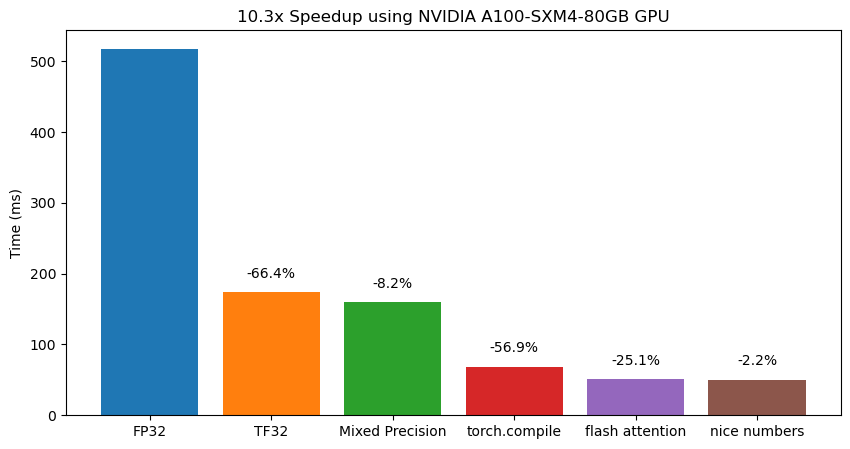

In [14]:
# Plot the time improvement with the different techniques
plt.figure(figsize=(10, 5))
i = 0
for k, v in times_dict.items():
    plt.bar(k, v)
    # on top of each bar write the percentage of reduction from the previous one
    if i == 0:
        prev = v
    else:
        plt.text(i, v + 20, f"-{(prev - v) / prev * 100:.1f}%", ha="center")
        prev = v
    i += 1

speedup = times_dict[list(times_dict.keys())[0]] / v
# plot the total reduction from last to first
plt.ylabel("Time (ms)")
plt.title(f"{speedup:0.1f}x Speedup using {torch.cuda.get_device_name()} GPU")
plt.show()